In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import tensorflow as tf
import numpy as np
import random as rn

seed = 0 # Here sd means seed.
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)

from keras import backend as K
config = tf.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=config)
K.set_session(sess)

/home/jorge/anaconda3/envs/machinelearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jorge/anaconda3/envs/machinelearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jorge/anaconda3/envs/machinelearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jorge/anaconda3/

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.layers import Attention
#from attention_decoder import AttentionDecoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import max_error
import seaborn as sns
from keras.callbacks import History 
from sklearn.model_selection import KFold 
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import Bidirectional
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

In [4]:
path = os.getcwd()
folder = path+"/dataset/ts_jorge_MW8.6/"
print(folder)

/home/jorge/tsunami-warning/dataset/ts_jorge_MW8.6/


In [5]:
df = pd.read_json(folder+'DataFrame_boyas14_80viña.json') # cargar dataframe

In [6]:
index = pd.date_range('25/8/2020', periods=len(df), freq='S')
Datetime = pd.DataFrame({'Datetime':index})

In [7]:
df = pd.concat([Datetime, df], axis=1,)

In [8]:
df.head()

,Datetime,boyas14_ts002,inu_vina80_ts002,boyas14_ts034,inu_vina80_ts034,boyas14_ts035,inu_vina80_ts035,boyas14_ts043,inu_vina80_ts043,boyas14_ts050,...,boyas14_s_026,inu_vina80_s_026,boyas14_s_027,inu_vina80_s_027,boyas14_s_031,inu_vina80_s_031,boyas14_s_032,inu_vina80_s_032,boyas14_s_033,inu_vina80_s_033
0,2020-08-25 00:00:00,0.000000e+00,0,0.000000,0,0.000000e+00,0.0,0.000000,0,0.000000e+00,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0
1,2020-08-25 00:00:01,-8.289000e-07,0,0.000003,0,2.070000e-07,0.0,-0.000001,0,6.162000e-07,...,0.000002,0,0.000001,0,0.000002,0,-0.000002,0,0.000002,0
2,2020-08-25 00:00:02,-1.751200e-06,0,0.000008,0,3.802000e-07,0.0,-0.000003,0,1.357000e-06,...,0.000006,0,0.000003,0,0.000005,0,-0.000005,0,0.000006,0
3,2020-08-25 00:00:03,-2.761000e-06,0,0.000015,0,4.539000e-07,0.0,-0.000006,0,2.279000e-06,...,0.000012,0,0.000006,0,0.000010,0,-0.000009,0,0.000010,0
4,2020-08-25 00:00:04,-4.259300e-06,0,0.000036,0,-6.210000e-08,0.0,-0.000016,0,4.225900e-06,...,0.000033,0,0.000014,0,0.000022,0,-0.000016,0,0.000025,0


Text(0, 0.5, 'Altura de ola [m]')

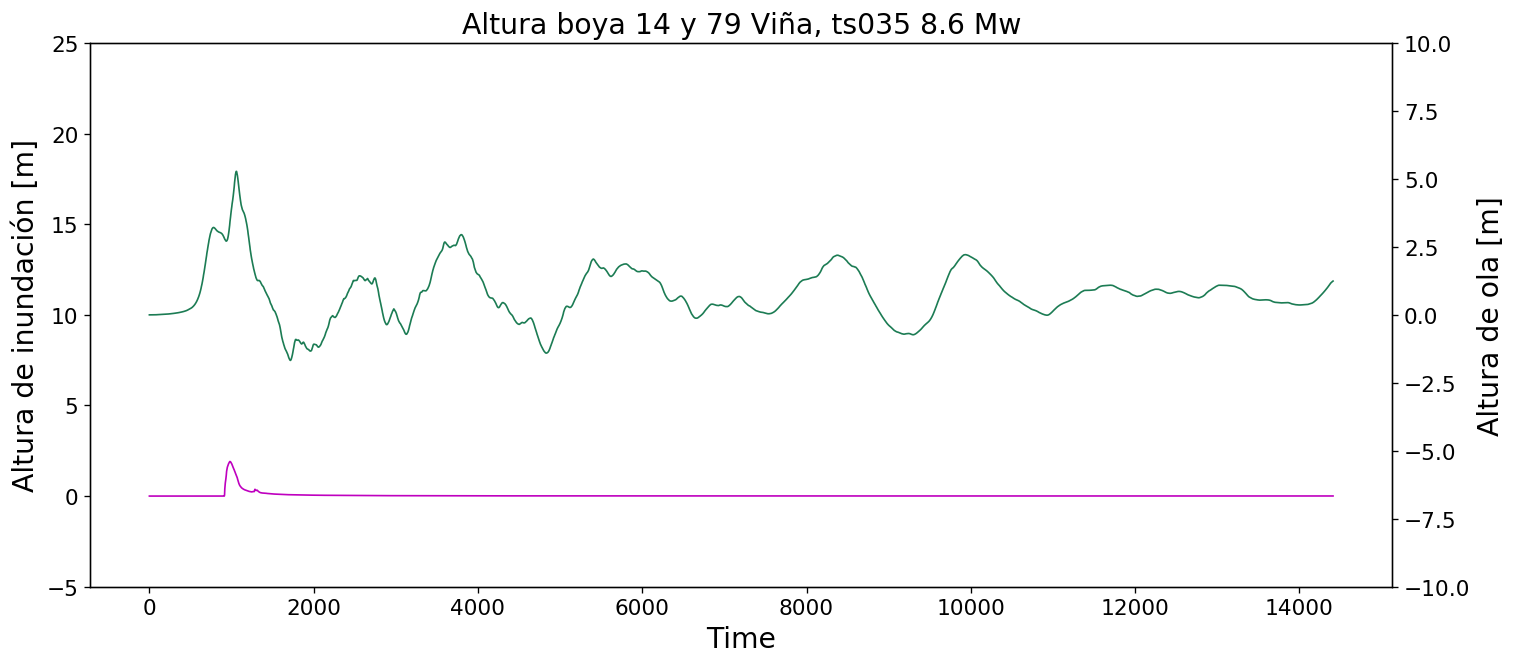

In [9]:
plt.figure(figsize=(14,6), dpi=120)

plt.ion()
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)
plt.title('Altura boya 14 y 79 Viña, ts035 8.6 Mw',fontsize=17)
plt.xlabel('Time',fontsize=17)
plt.ylabel('Altura de inundación [m]',fontsize=17)
plt.plot(df['inu_vina80_ts035'], color='m', linewidth=1.0)
plt.ylim(-5,25)
plt.twinx()
plt.plot(df['boyas14_ts035'], color='#1C7C54', linewidth=1.0)
plt.ylim(-10,10)
ax = plt.gca()
#ax.invert_yaxis()
plt.ylabel('Altura de ola [m]',fontsize=17)

In [10]:
df = df.loc[0:1799]

In [11]:
df.describe()

,boyas14_ts002,inu_vina80_ts002,boyas14_ts034,inu_vina80_ts034,boyas14_ts035,inu_vina80_ts035,boyas14_ts043,inu_vina80_ts043,boyas14_ts050,inu_vina80_ts050,...,boyas14_s_026,inu_vina80_s_026,boyas14_s_027,inu_vina80_s_027,boyas14_s_031,inu_vina80_s_031,boyas14_s_032,inu_vina80_s_032,boyas14_s_033,inu_vina80_s_033
count,1800.000000,1800.0,1800.000000,1800.0,1800.000000,1800.000000,1800.000000,1800.0,1800.000000,1800.0,...,1800.000000,1800.0,1800.000000,1800.0,1800.000000,1800.0,1800.000000,1800.0,1800.000000,1800.0
mean,-0.433800,0.0,-0.235181,0.0,1.158015,0.207875,-0.928534,0.0,-0.219982,0.0,...,-0.296373,0.0,0.319565,0.0,-0.153182,0.0,0.102229,0.0,-0.465063,0.0
std,0.420061,0.0,1.019874,0.0,1.697167,0.423211,0.918122,0.0,0.416684,0.0,...,0.804060,0.0,0.358794,0.0,0.594830,0.0,0.961273,0.0,0.772165,0.0
min,-1.245867,0.0,-2.250021,0.0,-1.674535,0.000000,-2.743775,0.0,-1.370380,0.0,...,-1.929690,0.0,-0.300941,0.0,-1.126895,0.0,-1.672304,0.0,-1.785110,0.0
25%,-0.874718,0.0,-1.024356,0.0,0.022575,0.000000,-1.608396,0.0,-0.332048,0.0,...,-0.989233,0.0,0.044441,0.0,-0.834826,0.0,-0.231895,0.0,-1.225483,0.0
50%,-0.254434,0.0,0.078103,0.0,0.467110,0.000000,-0.462249,0.0,-0.010850,0.0,...,0.015975,0.0,0.206554,0.0,0.044420,0.0,-0.023792,0.0,-0.254409,0.0
75%,-0.073615,0.0,0.522265,0.0,2.780331,0.173391,-0.160161,0.0,0.042208,0.0,...,0.242644,0.0,0.567479,0.0,0.355305,0.0,0.896284,0.0,0.164774,0.0
max,0.066499,0.0,1.348361,0.0,5.281328,1.905331,0.405796,0.0,0.376588,0.0,...,0.616518,0.0,1.132151,0.0,0.675025,0.0,2.281345,0.0,0.649617,0.0


In [12]:
df = df.resample('S', on='Datetime').mean()

Text(0, 0.5, 'Altura de ola [m]')

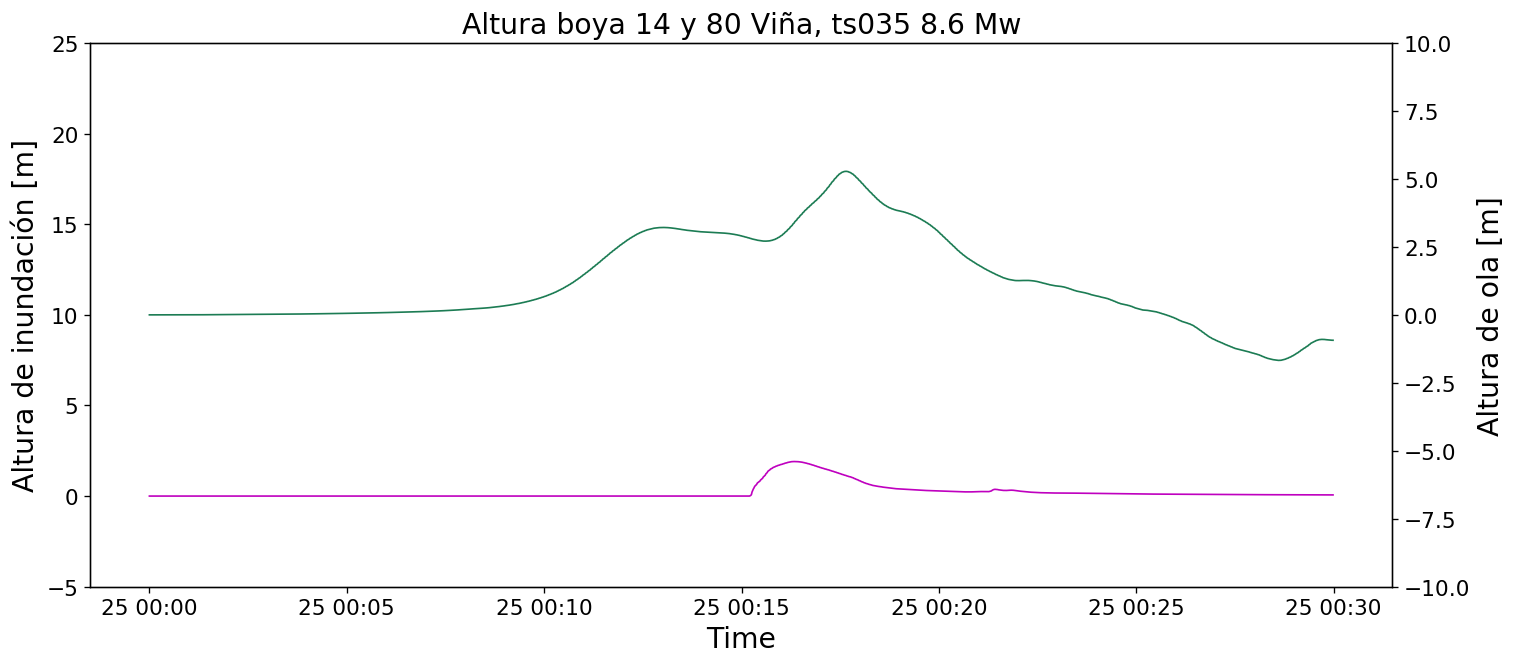

In [13]:
plt.figure(figsize=(14,6), dpi=120)

plt.ion()
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)
plt.title('Altura boya 14 y 80 Viña, ts035 8.6 Mw',fontsize=17)
plt.xlabel('Time',fontsize=17)
plt.ylabel('Altura de inundación [m]',fontsize=17)
plt.plot(df['inu_vina80_ts035'], color='m', linewidth=1.0)
plt.ylim(-5,25)
plt.twinx()
plt.plot(df['boyas14_ts035'], color='#1C7C54', linewidth=1.0)
plt.ylim(-10,10)
ax = plt.gca()
#ax.invert_yaxis()
plt.ylabel('Altura de ola [m]',fontsize=17)


In [14]:
df = df.resample('T').max()

Text(0, 0.5, 'Altura de ola [m]')

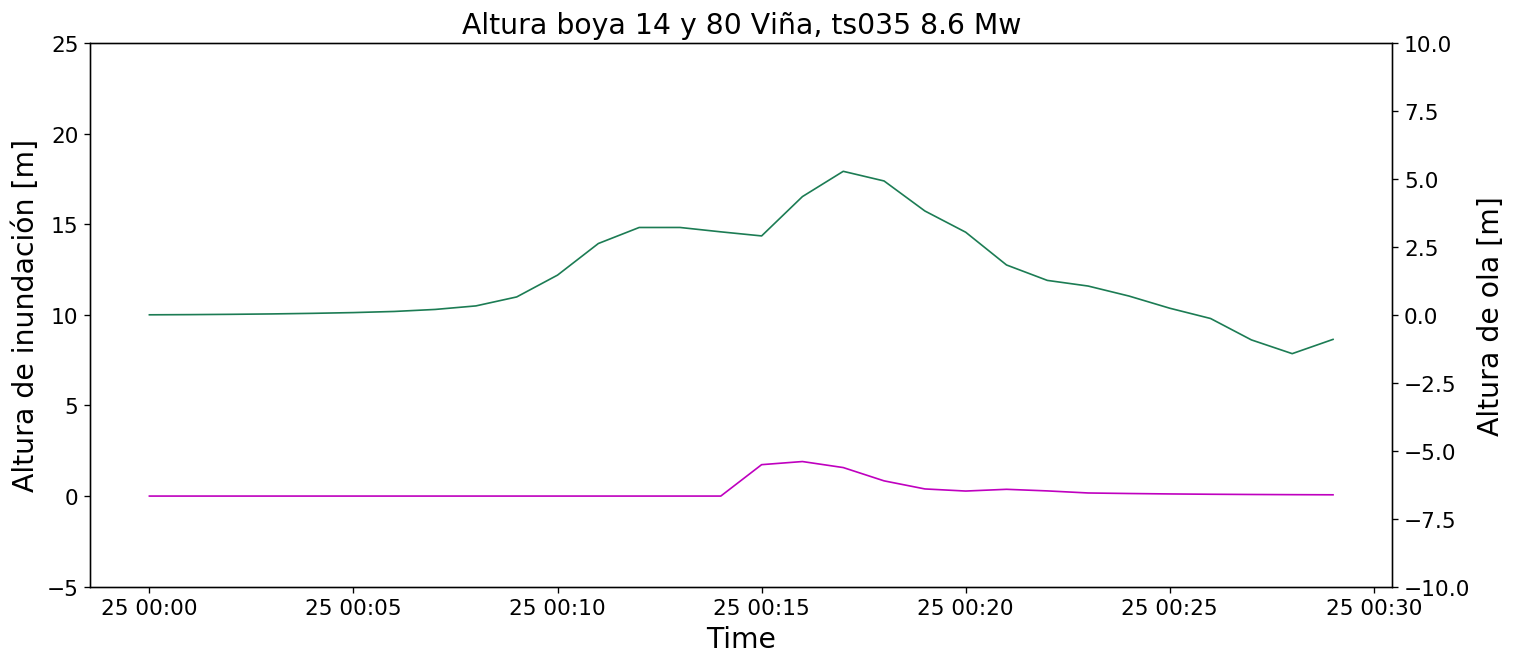

In [15]:
plt.figure(figsize=(14,6), dpi=120)

plt.ion()
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)
plt.title('Altura boya 14 y 80 Viña, ts035 8.6 Mw',fontsize=17)
plt.xlabel('Time',fontsize=17)
plt.ylabel('Altura de inundación [m]',fontsize=17)
plt.plot(df['inu_vina80_ts035'], color='m', linewidth=1.0)
plt.ylim(-5,25)
plt.twinx()
plt.plot(df['boyas14_ts035'], color='#1C7C54', linewidth=1.0)
plt.ylim(-10,10)
ax = plt.gca()
#ax.invert_yaxis()
plt.ylabel('Altura de ola [m]',fontsize=17)


In [16]:
df.describe()

,boyas14_ts002,inu_vina80_ts002,boyas14_ts034,inu_vina80_ts034,boyas14_ts035,inu_vina80_ts035,boyas14_ts043,inu_vina80_ts043,boyas14_ts050,inu_vina80_ts050,...,boyas14_s_026,inu_vina80_s_026,boyas14_s_027,inu_vina80_s_027,boyas14_s_031,inu_vina80_s_031,boyas14_s_032,inu_vina80_s_032,boyas14_s_033,inu_vina80_s_033
count,30.000000,30.0,30.000000,30.0,30.000000,30.000000,30.000000,30.0,30.000000,30.0,...,30.000000,30.0,30.000000,30.0,30.000000,30.0,30.000000,30.0,30.000000,30.0
mean,-0.394155,0.0,-0.089719,0.0,1.371253,0.271378,-0.806152,0.0,-0.163747,0.0,...,-0.214390,0.0,0.388731,0.0,-0.101210,0.0,0.229762,0.0,-0.390820,0.0
std,0.414798,0.0,1.011407,0.0,1.828753,0.530009,0.907281,0.0,0.402185,0.0,...,0.791118,0.0,0.386817,0.0,0.596063,0.0,1.018709,0.0,0.768537,0.0
min,-1.215326,0.0,-2.177659,0.0,-1.426765,0.000000,-2.684031,0.0,-1.247511,0.0,...,-1.801262,0.0,-0.054338,0.0,-1.083439,0.0,-1.511202,0.0,-1.750857,0.0
25%,-0.827186,0.0,-0.846643,0.0,0.040069,0.000000,-1.420789,0.0,-0.204250,0.0,...,-0.662403,0.0,0.071673,0.0,-0.743124,0.0,-0.213285,0.0,-1.026741,0.0
50%,-0.217094,0.0,0.170693,0.0,0.676391,0.034821,-0.349532,0.0,0.001221,0.0,...,0.057939,0.0,0.249767,0.0,0.068873,0.0,-0.002248,0.0,-0.197124,0.0
75%,-0.041528,0.0,0.726795,0.0,3.006577,0.250384,-0.109799,0.0,0.070798,0.0,...,0.301190,0.0,0.677601,0.0,0.384791,0.0,1.033767,0.0,0.206977,0.0
max,0.066499,0.0,1.348361,0.0,5.281328,1.905331,0.405796,0.0,0.376588,0.0,...,0.616518,0.0,1.132151,0.0,0.675025,0.0,2.281345,0.0,0.649617,0.0


In [17]:
#data_pre_train, data_pre_temp = train_test_split(data, test_size= 0.5)
#data_pre_val, data_pre_test = train_test_split(data_pre_temp, test_size= 0.4)

#scaler = StandardScaler().fit(df)
#df= pd.DataFrame(scaler.transform(df),
#                                 columns=df.columns)


In [18]:
xtest = df.pop('boyas14_ts035') # asigna y quita columna
ytest = df.pop('inu_vina80_ts035') # asigna y quita columna

In [19]:
df = df.values.astype('float32')
xtest = xtest.values.astype('float32')
ytest = ytest.values.astype('float32')

In [20]:
# genera secuencias de entrada y salida

def split_sequence(df):
    X, y = list(), list()
    for time in range(0,df.shape[1],2):
        # se suma uno porque no considera el ultimo
        seq_x, seq_y = df[:,time], df[:,time+1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


In [21]:
trainX,trainY = split_sequence(df)
testX,testY = xtest,ytest

In [22]:
n_features = 1
n_steps = trainX.shape[1]
print('n_steps :',n_steps)

n_steps : 30


In [23]:
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))


In [24]:
trainX.shape

(96, 30, 1)

In [25]:
trainY.shape

(96, 30)

In [26]:
groups = [0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,
          0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0]

**comentario :** Etiquetas para diferencias las escenarios que **Si inundan** y los que **No indundan**, debido a lo desbalanceada que esta la data aproximadamente solo el 18% de los escenarios inundan. 

## Stack LSTM.

In [27]:
import time
epoch = 150
Xm = trainX
ym = trainY
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
skf.get_n_splits(Xm, groups)
start = time.time()
# define model
hist = History()
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
#model.add(AttentionDecoder(30, n_features))
model.add(LSTM(150, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(60, activation='relu'))
model.add(Dense(n_steps))
model.compile(optimizer=Adam(lr=0.002), loss='mse')
# fit model
for train, test in skf.split(Xm, groups): #tscv.split(Xm):
    history = model.fit(Xm[train], ym[train],validation_data=(Xm[test], ym[test]), epochs=epoch, verbose=0
                        ,callbacks=[hist])
                        
#history=model.fit(trainX, trainY, epochs=epoch, verbose=1,callbacks=[hist])

end = time.time()

print('time execution',(end - start)/60)


time execution 7.205434850851694


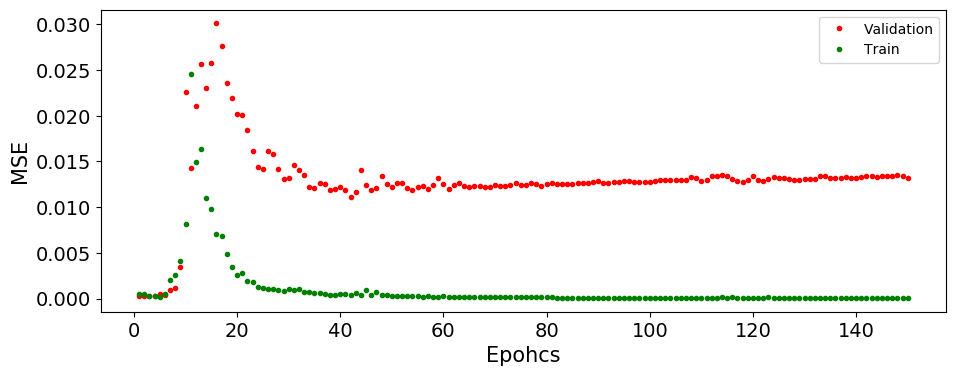

In [28]:
import matplotlib.pyplot as plt
a=np.linspace(1,epoch,epoch)
plt.figure(figsize=(24,4), dpi=100)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.subplot(1,2,1)
plt.plot(a,hist.history['val_loss'],'r.',label = 'Validation')
plt.plot(a,hist.history['loss'],'g.',label = 'Train')
plt.xlabel('Epohcs',fontsize=15)
plt.ylabel('MSE',fontsize=15)
plt.legend(loc='upper right')

In [29]:
trainX = df[:,50]
trainY = df[:,51]
trainX=trainX.reshape((1,n_steps,1))
testX=testX.reshape((1,n_steps,1))

In [30]:
trainPredict = (model.predict(trainX)).reshape(-1,1)
testPredict = (model.predict(testX)).reshape(-1,1)

In [31]:
# invert predictions
"""
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1,1))
trainY = scaler.inverse_transform(trainY.reshape(-1,1))
testPredict = scaler.inverse_transform(testPredict.reshape(-1,1))
testY = scaler.inverse_transform(testY.reshape(-1,1))
"""

'\ntrainPredict = scaler.inverse_transform(trainPredict.reshape(-1,1))\ntrainY = scaler.inverse_transform(trainY.reshape(-1,1))\ntestPredict = scaler.inverse_transform(testPredict.reshape(-1,1))\ntestY = scaler.inverse_transform(testY.reshape(-1,1))\n'

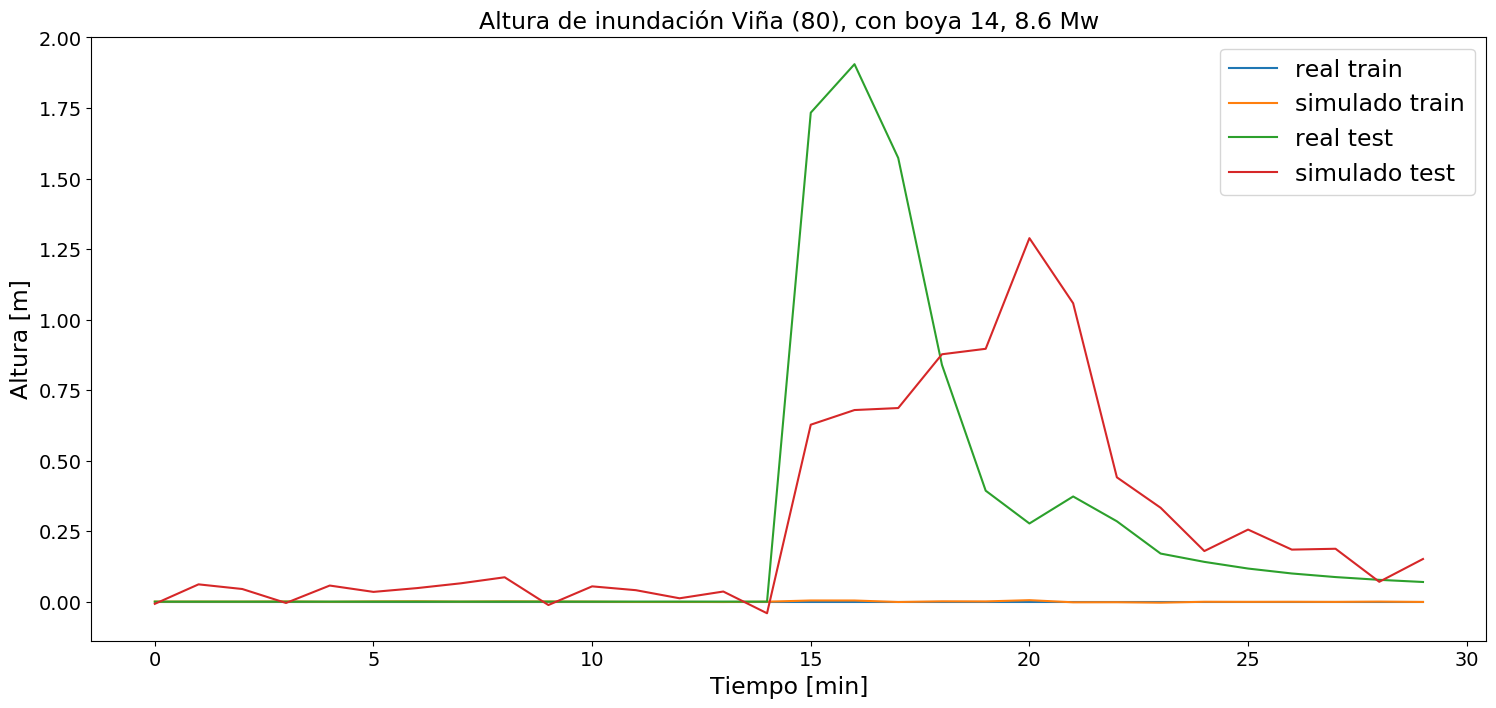

In [32]:
plt.figure(figsize=(18,8), dpi=100)

#plt.subplot(2,1,1)
plt.plot(trainY,label = 'real train')
plt.plot(trainPredict, label = 'simulado train')
plt.plot(testY,label = 'real test')
plt.plot(testPredict, label = 'simulado test')
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=17)
plt.title('Altura de inundación Viña (80), con boya 14, 8.6 Mw',fontsize=17)
plt.ylabel('Altura [m]',fontsize=17)
plt.xlabel('Tiempo [min]',fontsize=17)
plt.legend(loc='upper right',fontsize=17)

#plt.subplot(2,1,2)
#plt.plot(testY,label = 'real test')
#plt.plot(testPredict, label = 'simulado test')
#plt.rc('xtick', labelsize=17) 
#plt.rc('ytick', labelsize=17)
#plt.title('Altura de inundación boya 6 Valparaiso, E3 8.5 Mw',fontsize=17)
#plt.ylabel('Altura [m]',fontsize=17)
#plt.xlabel('Tiempo [s]',fontsize=17)
#plt.legend(loc='upper right',fontsize=17)

- buscar metrica que penalice mas el error de los maximos.
- buscar split que realice una separacion mas balanceada.
- probar modelo convolucional 1D. con atencion.
- transfer learning con autoencoder.
- capa attention en lstm
- revisar early stoping